In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import geom

# Problem Statement

Suppose we have a process that has a fixed, but unknown probability of occurring on any given attempt. We want to determine this probability, $p$ from experimental evidence.

An example of this would be a die with $N=40$ sides. On each roll, the probability of rolling a one is $p = \frac {1}{N} = 0.025$

Our experiment consists of a large number of repeated trials. In each trial, we roll the die until a one is observed and then record the number of rolls it took to get a one.

Sometimes we will get a 1 on the first roll. Occasionally it will take over 100 rolls until we get a 1. On average, it will take $N$ rolls. That is to say the expectation value, $$E = p = \frac {1}{N} = \frac {\text {number of trials}}{\sum{\text {experimental results}}}$$

However, because of time or resource constraints, we are not able to continue each trial until a one is observed. The number of rolls we are permitted in each trial varies between one and some upper limit, $\kappa$. We assume that this limit is a uniform distribution over the range $(0,\kappa)$. For this example, let's say $\kappa = 50$, meaning sometimes we will be permitted only 1 roll, other times we get as many as $50$ attempts. There is a $\frac {49}{50}$ chance that we are permitted fewer than 50 rolls.

# Procedure

Our experimental procedure is as follows:
1. Roll the die until we get either a 1 or we hit the timeout limit
1. If we get a 1 at any point, we mark this as `success = True` and record the number of the roll on which a 1 was observed. Generally this is going to be less than the timeout limit, which is generally less than the maximum limit $\kappa$
1. If we don't get a one, we record this as `success = False` and record the number of attempts.

Some example data is shown below:

In [2]:
p = 1/40  # The probability of getting a 1 on each roll
𝜅 = 50    # The maximum number of attempts we are permitted on each trial
N = 100000 # The number of trials in our experiment

df = pd.DataFrame()
df.index.name = 'trial'
rolls = geom(p).rvs(N)
timeouts = np.random.randint(1, 𝜅+1, size = N)
df['success'] = rolls<=timeouts
df['n'] = np.where(df['success'], rolls, timeouts)
df


,success,n
trial,,
0,False,33
1,False,24
2,False,15
3,True,28
4,False,9
...,...,...
99995,False,5
99996,True,16
99997,False,5


### Note that many of our trials (~45%) end without success

In [3]:
df['success'].mean()

0.43816

Here we plot the distribution of successful and unsuccessful trials.
Note that even though the timeout values are uniformly distributed, the distribution of timed-out trials is not uniform. This is because some number (the majority) end in success before timeout.

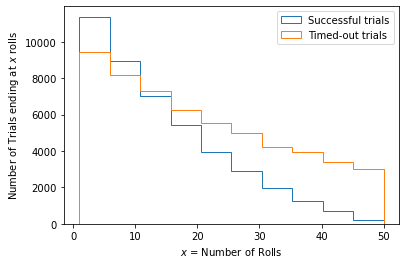

In [4]:
plt.hist(df[df['success']]['n'], histtype='step', label = 'Successful trials');
plt.hist(df[~df['success']]['n'], histtype='step', label = 'Timed-out trials')
plt.xlabel('$x$ = Number of Rolls')
plt.ylabel('Number of Trials ending at $x$ rolls')
plt.legend();

Note also that is we just take the average of the resulting values (as we would if there were no time-outs), we get an estimate of $N$ that is very far away from its true value.

In [5]:
df['n'].mean()

17.61121

# Analysis

To analyze this data and get a valid estimate of $N$, we use the following procedure.

## Timeouts:
In order for a trial to end in timeout on the $n^{th}$ role, the following conditions must be  met:
* None of the previous $n-1$ rolls were successful.
$$\text {condition A} = (1-p)^{n-1}$$
* None of the previous rolls were the timeout value. Because the timeout values are distributed uniformly, the probability that the timeout is less than $n$ is $\frac {n-1}{𝜅}$ and the chance that the timeout value is *not* less than $n$ is:
$$\text {conditon B} = 1-\frac {n-1}{𝜅}$$
* The current roll $n$ is the timeout value. As $n \to 𝜅$, the probability that $n$ is the timeout value increase as the remaining values decrease. E.g, on the first roll, there is a $\frac {1}{50}$ chance that it will be the last permitted attempt. On the second roll, there is a $\frac {1}{49}$ chance, on the $50^{th} or 𝜅^{th}$ roll, we know for certainty that it will be the last permitted roll. Therefore:
$$\text {condition C} = \frac {1}{𝜅-n+1}$$
This takes the value $\frac {1}{𝜅}$ when $n=1$ and $1$ when $n = 𝜅$. And, of course, $n$ cannot exceed $𝜅$
* The final roll, $n$ is not successful:
$$\text {condition D} = (1-p)$$

The probability that all of these conditions are met for any value of $n$ in the range $1..𝜅$ is
$$\text {Timeouts} = A\cap B\cap C\cap D = (1-p)^{n}\cdot \frac {1}{𝜅-n+1}\cdot \left (1-\frac {n-1}{𝜅}\right )$$

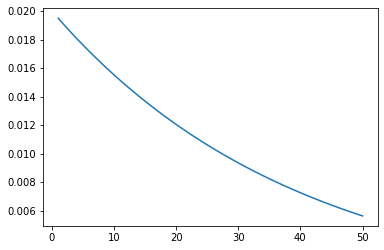

In [6]:
n = np.linspace(1,𝜅,𝜅)
Timeout = (1-p)**(n)*(1/(𝜅-n+1))*(1-(n-1)/𝜅)
plt.plot(n, Timeout);

We can observe this in our experimental data as the normalized number of trials ending without success at each value of $n$ on the interval $(1..𝜅)$

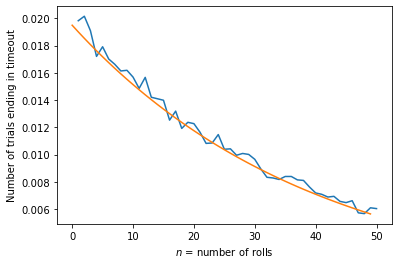

In [7]:
empirical_timeouts = df[~df['success']].groupby('n').count()/len(df)

plt.plot(empirical_timeouts)
plt.plot(Timeout)
plt.xlabel('$n$ = number of rolls')
plt.ylabel('Number of trials ending in timeout');

## Successful Runs

By similar logic, we can identify the conditions necessary for a successful trial, that is one that ends when a 1 is rolled on or before the timeout.

* None of the previous $n-1$ rolls yielded a 1:
$$\text {condition X} = (1-p)^{n-1}$$

* None of the previous runs resulted in timeout:
$$\text {conditon Y} = 1 - \frac {n-1}{𝜅}$$

* The current run, $n$ does result in a 1:
$$\text {condition Z} = p$$

The probability that all of these conditions is met for any value of $n$ is:

$$\text {Successes} = X\cap Y\cap Z = p\cdot (1-p)^{n-1}\cdot \left (1 - \frac {n-1}{𝜅}\right )$$

We can compare this value to the empirical evidence of successful runs:

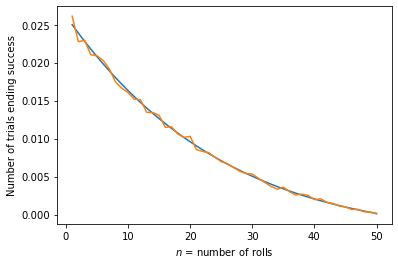

In [8]:
Successes = p*(1-p)**(n-1)*(1-(n-1)/𝜅)
empirical_successes = df[df['success']].groupby('n').count()/len(df)

plt.plot(n, Successes)
plt.plot(empirical_successes)
plt.xlabel('$n$ = number of rolls')
plt.ylabel('Number of trials ending success');

## Success Ratio

Next we combine these equations for Successes and Timeouts to get the probability that a trial will be successful at any value of $n$.

$$P_{success} = \frac {Successes}{Successes + Timeouts}$$

$$= \frac {1}{1+\frac {Timeouts}{Successes}}$$

$$ = \frac {1}{1+ \frac {(1-p)^{n}\cdot \frac {1}{𝜅-n+1}\cdot \left (1-\frac {n-1}{𝜅}\right )}{p\cdot (1-p)^{n-1}\cdot \left (1 - \frac {n-1}{𝜅}\right )}}$$

This success ratio can also be determined empirically:

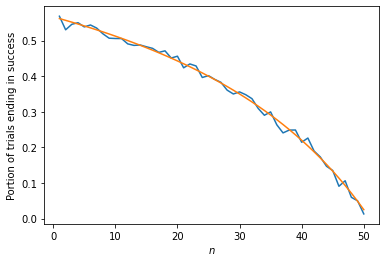

In [9]:
success_ratio = df.groupby('n')['success'].mean()
success_ratio.plot()
plt.plot(n, Successes/(Timeout+Successes))
plt.xlabel('$n$')
plt.ylabel('Portion of trials ending in success');

## Estimated probability

All of the values in the equation for $P_{success}$ except for $p$ can be determined from the empirical data.

We can rearrange and solve for $p$:

$$p = \frac {P_{success}}{n\cdot (P_{success}-1) - 𝜅\cdot P_{success} + 𝜅+1}$$

This gives us a value of $p$ estimated for each value of $n$

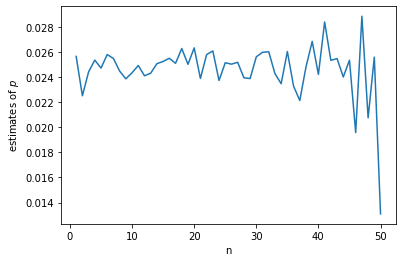

In [10]:
estimates_of_p = success_ratio/(n*(success_ratio-1)-𝜅*success_ratio+𝜅+1)
plt.plot(n, estimates_of_p)
plt.xlabel('n')
plt.ylabel('estimates of $p$');

## Final Estimate of $p$

To determine the final estimate of $p$, we take the sum of these estimates of $p(n)$, weighted by the normalized number of observations at each value of $n$

In [11]:
weights = df.groupby('n').count().values.flatten()/len(df)

final_estimate_of_p = (weights*estimates_of_p).sum()

We see that this value compares favorably to our specified value of $p$

In [12]:
final_estimate_of_p, p

(0.024780278679153722, 0.025)

# Conclusion

A good estimate of $p$ (and $N=\frac {1}{p}$) can be obtained entirely from the empirical data using the following code:

In [13]:
P = df.groupby('n')['success'].mean()
n_observations = df.groupby('n').count().values.flatten()/len(df)
kappa = df['n'].max()

empirical_p = (P/(n*(P-1)-kappa*P+kappa+1)*n_observations).sum()

empirical_p, 1/empirical_p

(0.024780278679153722, 40.35467126692343)

### Footnote:

By replace $p = 1/40$ with $p = 1/400$ at the top of this notebook, you can see that this method works remarkably well, even for small ratios of $\frac {𝜅}{N}$ when over 90% of the trials end in timeout.